In [1]:
import matplotlib.pyplot as plt
import cyipopt as ipopt
import numpy as np

from vessel_models import VesselModel
from controller import MPC

In [2]:
# Simulation variables
N = 100
dt = 0.1
ns = 6
nu = 3

N_mpc = 10
N_sim = N + N_mpc

# Cost matrices
Qvec = 3*np.ones(ns)
Rvec = np.ones(nu)
Qfvec = 10*np.ones(ns)

# Reference trajectory
Sload = np.loadtxt('dircol_soln.csv', delimiter=',')
Sf = Sload[-1]
Sref = np.tile(Sf, (N_sim, 1))
Sref[:N] = Sload

model = VesselModel(mismatch=True)
print(model.m)

{'X_u': -1.1537554681951312, 'X_uu': -1.5386495095469583, 'Y_v': -0.7212039284390908, 'Y_vv': -70.43643083141656, 'Y_r': 0.6873756640710956, 'N_v': 0.5411167304925247, 'N_r': -0.3745807736899299, 'N_rr': -0.5692018891770936, 'X_du': -2.3282579385563267, 'Y_dv': -19.09002311428855, 'Y_dr': 0.5613481454959484, 'N_dv': 0.22992015669508115, 'N_dr': -0.7503680447189495, 'm': 40.539216412640684, 'I_z': 3.4378995478912877, 'x_g': 0.5277061756427329}
40.539216412640684


In [3]:
U_soln = np.zeros((N-1, nu))
S_soln = np.zeros((N, ns))
S_soln[0] = Sref[0]

for i in range(N-1):
    s0 = S_soln[i]
    sf = Sref[i+N_mpc-1]
    sref = Sref[i:i+N_mpc]
    trajoptimizer = MPC(model, N_mpc, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf, sref)
    trajoptimizer.exec_MPC()
    S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
    U_soln[i] = U[0]
    S_soln[i+1] = model.rk4(s0, U[0], dt)
    


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5742
Number of nonzeros in inequality constraint Jacobian.:     4698
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       87
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       66
Total number of inequality constrai

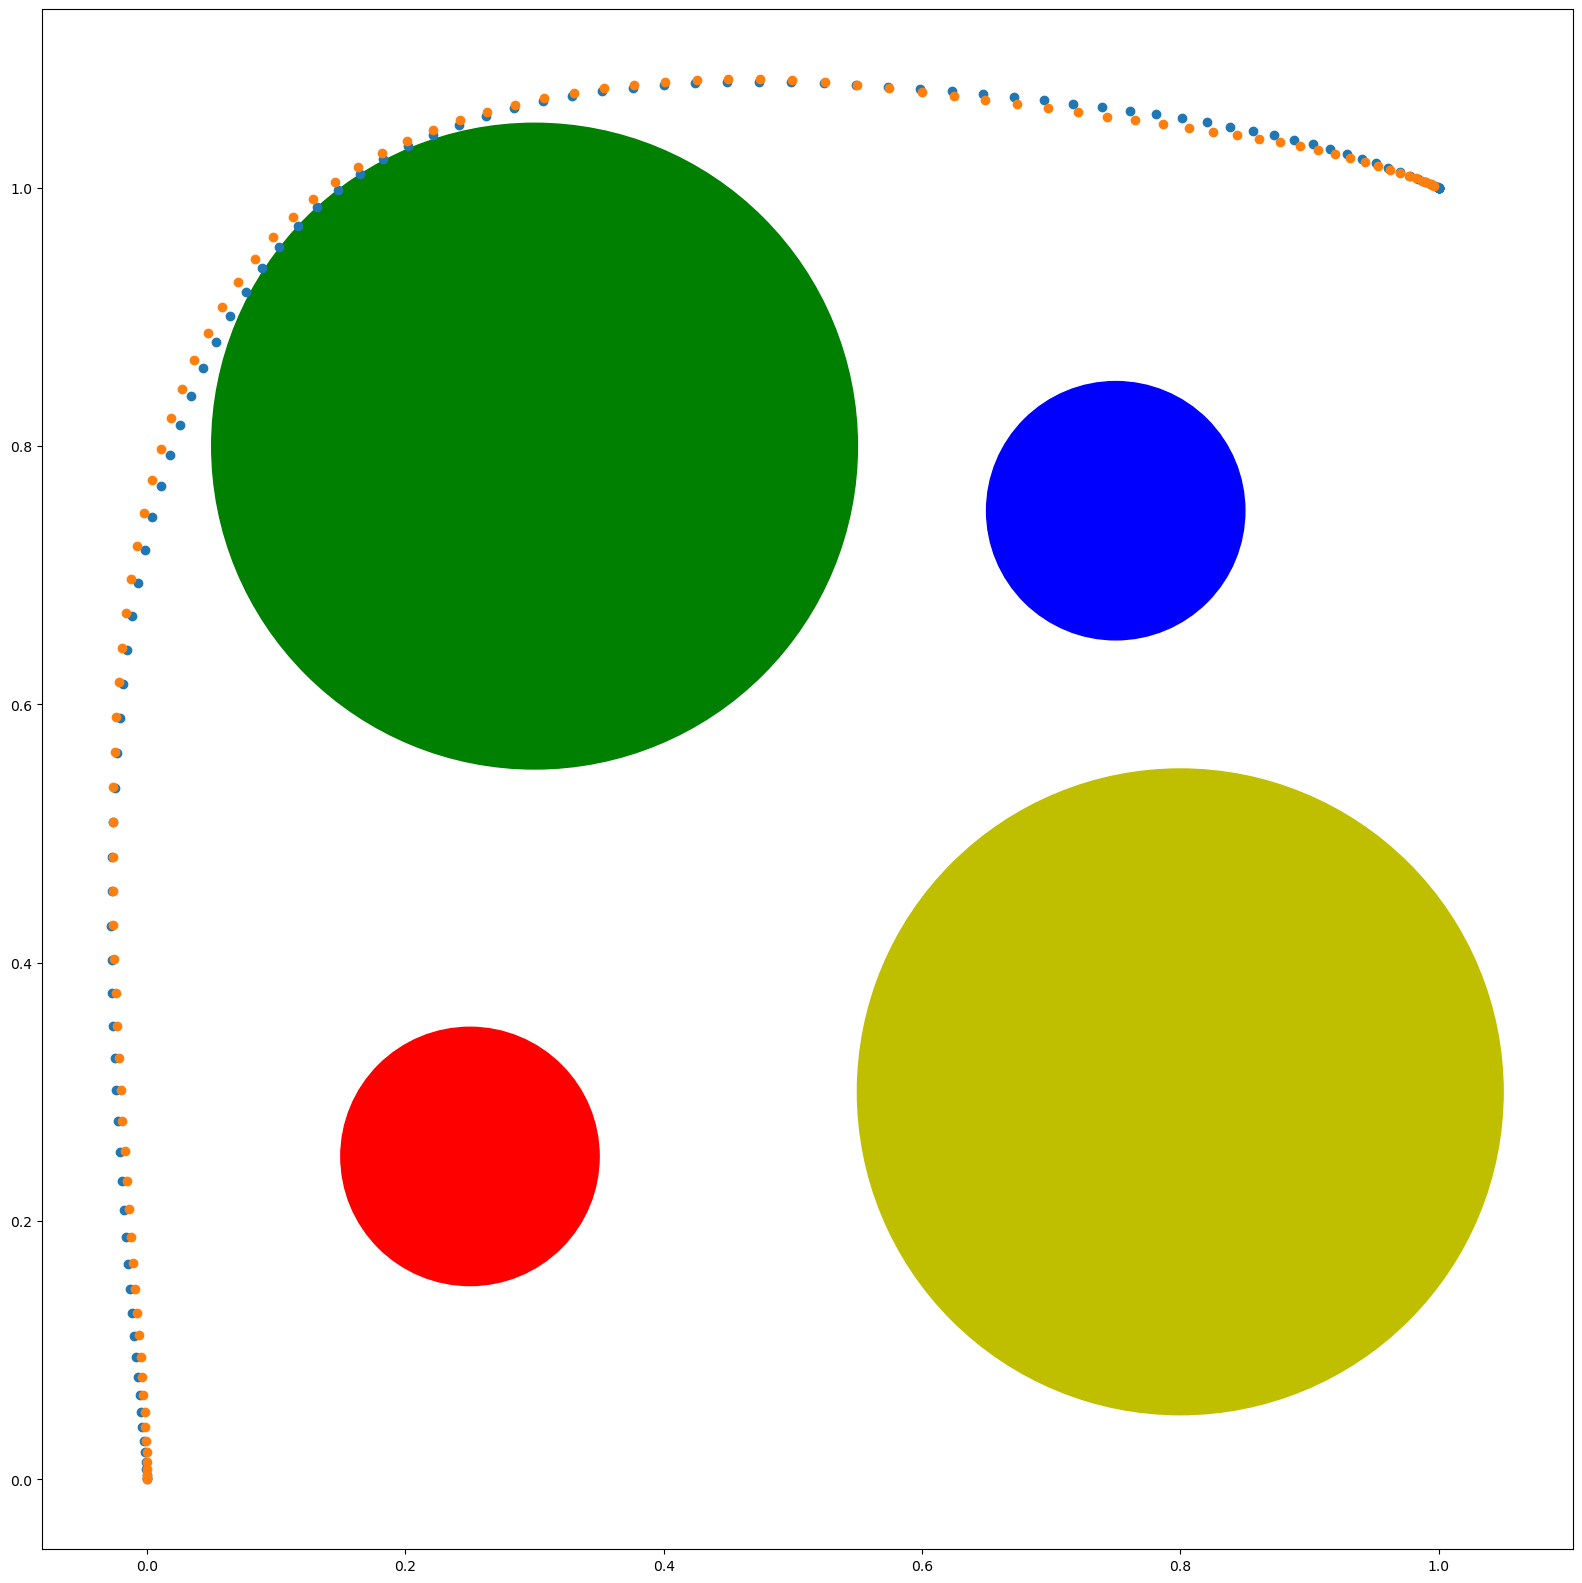

In [4]:
Sfwd = np.zeros((N,ns))
Sfwd[0] = Sref[0]
for i in range(N-1):
    Sn = Sfwd[i]
    Un = U_soln[i]
    Sfwd[i+1] = model.rk4(Sn, Un, dt)

ps = Sfwd.T
ps_ref = Sref.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
circle1 = plt.Circle((0.25, 0.25), 0.1, color='r')
circle2 = plt.Circle((0.3, 0.8), 0.25, color='g')
circle3 = plt.Circle((0.75, 0.75), 0.1, color='b')
circle4 = plt.Circle((0.8, 0.3), 0.25, color='y')
axes.add_patch(circle1)
axes.add_patch(circle2)
axes.add_patch(circle3)
axes.add_patch(circle4)
axes.scatter(ps_ref[1], ps_ref[0])
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()